**Finetuning the ConvNet:** Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

**ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/hymenoptera/hymenoptera' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


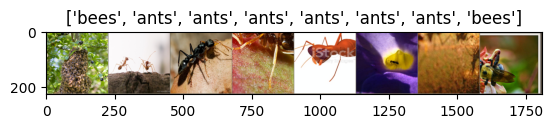

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Fine Tuning the model
Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate

- Saving the best model

So basically **early stoping**

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning it Now !!

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Optimizers and Hyperparameters that I tried and there accuracy

- **Adam optimizer**, **lr** = 0.0001 : **accuracy** 73.64
- **AdamW optimizer**, **lr** = 0.0001 : **accuracy** 88.94
- **SGD optimizer**, **lr** = 0.0001 : **accuracy** 91.29
- **SGD optimizer**, **lr** = 0.001 : **accuracy** 92.11
- **SGD optimizer**, **lr** = 0.001, **momentum** = 0.9 : **accuracy** 95.42 (Default)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5781 Acc: 0.7295
val Loss: 0.3710 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.3824 Acc: 0.8115
val Loss: 0.2359 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4037 Acc: 0.8566
val Loss: 0.2181 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.2167 Acc: 0.9139
val Loss: 0.2164 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1949 Acc: 0.9139
val Loss: 0.1921 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.2752 Acc: 0.8852
val Loss: 0.1657 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1755 Acc: 0.9180
val Loss: 0.1738 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.1840 Acc: 0.9385
val Loss: 0.1755 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.1460 Acc: 0.9426
val Loss: 0.1555 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.1412 Acc: 0.9303
val Loss: 0.1487 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0910 Acc: 0.9631
val Loss: 0.1480 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2304 Acc: 0.9016
val Loss: 0.1494 Acc: 0.9477

Ep

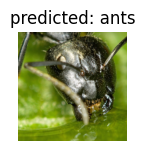

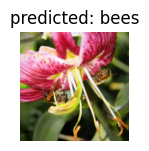

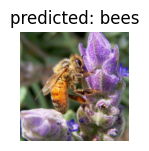

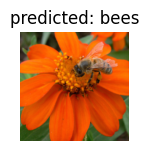

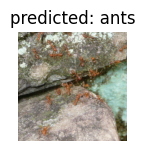

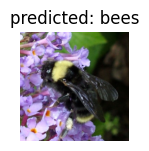

In [8]:
visualize_model(model_ft)

## Transfer Learning

In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Optimizers and Hyperparameters that I tried and there accuracy

- **Adam optimizer**, **lr** = 0.0001 : **accuracy** 85.62
- **AdamW optimizer**, **lr** = 0.0001 : **accuracy** 85.62
- **SGD optimizer**, **lr** = 0.0001 : **accuracy** 65.35
- **SGD optimizer**, **lr** = 0.001 : **accuracy** 92.15
- **SGD optimizer**, **lr** = 0.001, **momentum** = 0.9 : **accuracy** 96.84 (Default)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6329 Acc: 0.6557
val Loss: 0.2902 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4149 Acc: 0.8197
val Loss: 0.2111 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3648 Acc: 0.8279
val Loss: 0.1875 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3250 Acc: 0.8607
val Loss: 0.1809 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3169 Acc: 0.8893
val Loss: 0.1787 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.2931 Acc: 0.8730
val Loss: 0.1776 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2820 Acc: 0.8770
val Loss: 0.1766 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.1933 Acc: 0.9221
val Loss: 0.1736 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2395 Acc: 0.9057
val Loss: 0.1742 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2437 Acc: 0.8893
val Loss: 0.1775 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2405 Acc: 0.8852
val Loss: 0.1691 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2149 Acc: 0.9180
val Loss: 0.1745 Acc: 0.9477

Ep

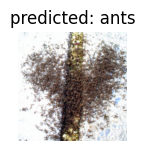

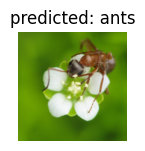

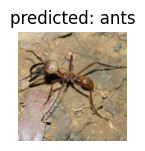

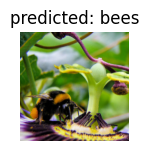

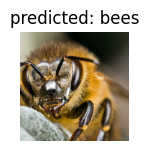

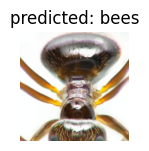

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Pre-train ResNet18 on the dataset

In [12]:
pre_train_model = torchvision.models.resnet18(weights=None)
pre_train_model = pre_train_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_pre = optim.SGD(pre_train_model.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_pre, step_size=7, gamma=0.1)

## Optimizers and Hyperparameters that I tried and there accuracy

- **Adam optimizer**, **lr** = 0.0001 : **accuracy** 75.81
- **AdamW optimizer**, **lr** = 0.0001 : **accuracy** 76.47
- **SGD optimizer**, **lr** = 0.0001 : **accuracy** 61.43
- **SGD optimizer**, **lr** = 0.001 : **accuracy** 69.28
- **SGD optimizer**, **lr** = 0.001, **momentum** = 0.9 : **accuracy** 71.24 (Default)

In [13]:
pre_train_model = train_model(pre_train_model, criterion, optimizer_pre,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.0715 Acc: 0.4795
val Loss: 0.6887 Acc: 0.6144

Epoch 1/24
----------
train Loss: 0.6622 Acc: 0.6311
val Loss: 0.7150 Acc: 0.6340

Epoch 2/24
----------
train Loss: 0.7489 Acc: 0.5820
val Loss: 0.8063 Acc: 0.5752

Epoch 3/24
----------
train Loss: 0.6908 Acc: 0.6107
val Loss: 0.9764 Acc: 0.5425

Epoch 4/24
----------
train Loss: 0.6681 Acc: 0.6393
val Loss: 0.7021 Acc: 0.5948

Epoch 5/24
----------
train Loss: 0.6516 Acc: 0.6516
val Loss: 0.5881 Acc: 0.6732

Epoch 6/24
----------
train Loss: 0.6523 Acc: 0.6025
val Loss: 0.6145 Acc: 0.6601

Epoch 7/24
----------
train Loss: 0.5684 Acc: 0.7008
val Loss: 0.5955 Acc: 0.6732

Epoch 8/24
----------
train Loss: 0.5906 Acc: 0.6557
val Loss: 0.5984 Acc: 0.6797

Epoch 9/24
----------
train Loss: 0.5422 Acc: 0.6926
val Loss: 0.5729 Acc: 0.6993

Epoch 10/24
----------
train Loss: 0.5605 Acc: 0.7008
val Loss: 0.6263 Acc: 0.6601

Epoch 11/24
----------
train Loss: 0.5276 Acc: 0.7213
val Loss: 0.5920 Acc: 0.6863

Ep

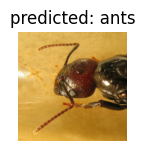

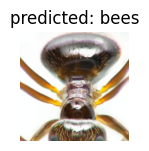

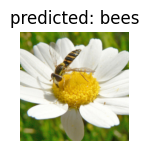

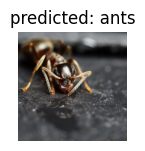

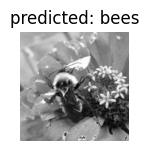

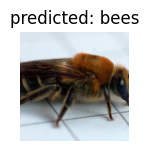

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()